In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm

import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/who-life-expectancy-prediction/training data.csv
/kaggle/input/who-life-expectancy-prediction/testing data.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/who-life-expectancy-prediction/training data.csv")
test_df = pd.read_csv("/kaggle/input/who-life-expectancy-prediction/testing data.csv")

In [3]:
train_df.head(6)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Malta,2008,Developed,80.0,64.0,0,7.14,2655.573684,86.0,1,...,72.0,8.15,72.0,0.1,21928.767000,49379.0,0.7,0.7,0.813,14.6
1,Congo,2005,Developing,55.3,394.0,8,2.03,0.000000,NaN,146,...,62.0,2.42,62.0,5.9,NaN,NaN,8.8,8.5,0.496,9.4
2,Burkina Faso,2009,Developing,56.9,283.0,44,4.55,81.143047,92.0,54118,...,91.0,7.41,92.0,1.1,552.745552,1514199.0,9.3,8.8,0.356,5.9
3,Guinea-Bissau,2011,Developing,57.1,289.0,4,3.57,40.453674,86.0,0,...,85.0,5.46,86.0,5.7,692.699890,1596154.0,7.8,7.7,0.410,9.0
4,Myanmar,2007,Developing,64.5,217.0,58,0.26,0.530573,85.0,1088,...,84.0,1.68,86.0,0.6,41.451000,49171586.0,13.2,13.5,0.484,8.1
5,Libya,2009,Developing,72.7,132.0,2,0.01,63.551703,98.0,329,...,98.0,3.16,98.0,0.1,1296.973530,NaN,5.6,5.4,0.757,14.6


In [4]:
print(train_df["Status"].unique())

['Developed' 'Developing']


Dataframe has nan values

In [5]:
train_df.describe

<bound method NDFrame.describe of             Country  Year      Status  Life expectancy   Adult Mortality  \
0             Malta  2008   Developed              80.0             64.0   
1             Congo  2005  Developing              55.3            394.0   
2      Burkina Faso  2009  Developing              56.9            283.0   
3     Guinea-Bissau  2011  Developing              57.1            289.0   
4           Myanmar  2007  Developing              64.5            217.0   
...             ...   ...         ...               ...              ...   
2051          Malta  2011   Developed              87.0             59.0   
2052  Guinea-Bissau  2010  Developing              56.7            287.0   
2053          Haiti  2007  Developing              61.8            266.0   
2054          Italy  2003   Developed              79.9             72.0   
2055        Eritrea  2005  Developing              59.4             34.0   

      infant deaths  Alcohol  percentage expenditure 

In [6]:
train_df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                      6
Adult Mortality                      6
infant deaths                        0
Alcohol                            136
percentage expenditure               0
Hepatitis B                        370
Measles                              0
 BMI                                24
under-five deaths                    0
Polio                               11
Total expenditure                  158
Diphtheria                          11
 HIV/AIDS                            0
GDP                                297
Population                         444
 thinness  1-19 years               24
 thinness 5-9 years                 24
Income composition of resources    110
Schooling                          109
dtype: int64

In [7]:
columns = train_df.columns
print(columns)
print(train_df.shape)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')
(2056, 22)


In [8]:
le = LabelEncoder()
categorical_cols = ["Status"]
train_df[categorical_cols] = train_df[categorical_cols].apply(lambda col: le.fit_transform(col))
test_df[categorical_cols] = test_df[categorical_cols].apply(lambda col: le.fit_transform(col))
train_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Malta,2008,0,80.0,64.0,0,7.14,2655.573684,86.0,1,...,72.0,8.15,72.0,0.1,21928.767000,49379.0,0.7,0.7,0.813,14.6
1,Congo,2005,1,55.3,394.0,8,2.03,0.000000,NaN,146,...,62.0,2.42,62.0,5.9,NaN,NaN,8.8,8.5,0.496,9.4
2,Burkina Faso,2009,1,56.9,283.0,44,4.55,81.143047,92.0,54118,...,91.0,7.41,92.0,1.1,552.745552,1514199.0,9.3,8.8,0.356,5.9
3,Guinea-Bissau,2011,1,57.1,289.0,4,3.57,40.453674,86.0,0,...,85.0,5.46,86.0,5.7,692.699890,1596154.0,7.8,7.7,0.410,9.0
4,Myanmar,2007,1,64.5,217.0,58,0.26,0.530573,85.0,1088,...,84.0,1.68,86.0,0.6,41.451000,49171586.0,13.2,13.5,0.484,8.1


In [9]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(train_df.drop(["Country", "Year", "Status"], axis=1))
train_imputed = pd.DataFrame(imputer.transform(train_df.drop(["Country", "Year", "Status"], axis=1)))
train_imputed.columns = columns[3:]
train_imputed["Status"] = train_df["Status"]
train_imputed.isna().sum()

Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Status                             0
dtype: int64

In [10]:
train_imputed.head()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status
0,80.0,64.0,0.0,7.14,2655.573684,86.0,1.0,66.6,0.0,72.0,8.15,72.0,0.1,21928.767000,49379.0,0.7,0.7,0.813,14.6,0
1,55.3,394.0,8.0,2.03,0.000000,57.6,146.0,21.7,13.0,62.0,2.42,62.0,5.9,330.141007,2319613.2,8.8,8.5,0.496,9.4,1
2,56.9,283.0,44.0,4.55,81.143047,92.0,54118.0,16.1,77.0,91.0,7.41,92.0,1.1,552.745552,1514199.0,9.3,8.8,0.356,5.9,1
3,57.1,289.0,4.0,3.57,40.453674,86.0,0.0,23.7,7.0,85.0,5.46,86.0,5.7,692.699890,1596154.0,7.8,7.7,0.410,9.0,1
4,64.5,217.0,58.0,0.26,0.530573,85.0,1088.0,17.6,78.0,84.0,1.68,86.0,0.6,41.451000,49171586.0,13.2,13.5,0.484,8.1,1


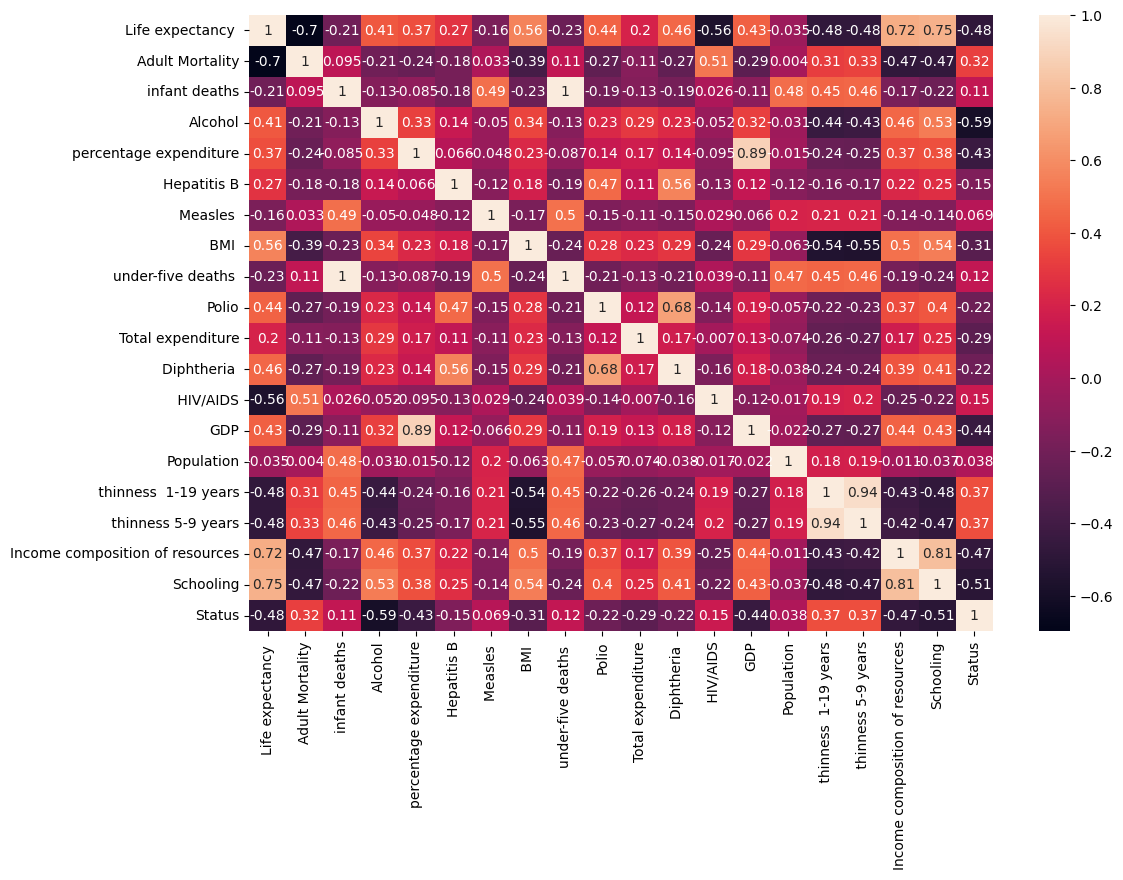

In [11]:
correlations = train_imputed.corr()
%matplotlib inline

plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestRegressor
print(train_imputed.columns)
X = train_imputed.drop('Life expectancy ', axis=1)  # Features
y = train_imputed['Life expectancy ']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
feature_importances = rf_regressor.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X_train is your training features DataFrame
    'Importance': feature_importances
})
features_df.sort_values(by='Importance', ascending=False, inplace=True)
print(features_df)

Index(['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Status'],
      dtype='object')
                            Feature  Importance
11                         HIV/AIDS    0.472122
16  Income composition of resources    0.317397
0                   Adult Mortality    0.105516
17                        Schooling    0.019829
2                           Alcohol    0.012425
6                              BMI     0.009861
15               thinness 5-9 years    0.009661
7                under-five deaths     0.008150
9                 Total expenditure    0.007419
14             thinness  1-19 years    0.005298
1                     infant deaths    0.005037
12                     

In [13]:
select_features_df = train_imputed.drop(["infant deaths"], axis=1)

In [14]:
from sklearn.model_selection import KFold

X = select_features_df.drop(["Life expectancy "], axis=1)
y = select_features_df["Life expectancy "]

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare an array to store the models for each fold
models = []

# K-Fold Cross Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Creating and fitting the LGBM Regressor
    lgb_regressor = lgbm.LGBMRegressor(n_estimators=100, random_state=42,metric="mae")
    lgb_regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # Storing the model
    models.append(lgb_regressor)

[1]	valid_0's l1: 6.94333
[2]	valid_0's l1: 6.3189
[3]	valid_0's l1: 5.73921
[4]	valid_0's l1: 5.22661
[5]	valid_0's l1: 4.7663
[6]	valid_0's l1: 4.358
[7]	valid_0's l1: 3.99336
[8]	valid_0's l1: 3.66332
[9]	valid_0's l1: 3.38477
[10]	valid_0's l1: 3.13974
[11]	valid_0's l1: 2.9092
[12]	valid_0's l1: 2.71917
[13]	valid_0's l1: 2.54889
[14]	valid_0's l1: 2.40389
[15]	valid_0's l1: 2.26944
[16]	valid_0's l1: 2.1593
[17]	valid_0's l1: 2.06369
[18]	valid_0's l1: 1.98079
[19]	valid_0's l1: 1.90627
[20]	valid_0's l1: 1.83663
[21]	valid_0's l1: 1.78605
[22]	valid_0's l1: 1.73854
[23]	valid_0's l1: 1.70587
[24]	valid_0's l1: 1.67092
[25]	valid_0's l1: 1.64992
[26]	valid_0's l1: 1.62394
[27]	valid_0's l1: 1.61121
[28]	valid_0's l1: 1.59805
[29]	valid_0's l1: 1.5829
[30]	valid_0's l1: 1.57046
[31]	valid_0's l1: 1.5627
[32]	valid_0's l1: 1.54953
[33]	valid_0's l1: 1.53705
[34]	valid_0's l1: 1.52414
[35]	valid_0's l1: 1.51309
[36]	valid_0's l1: 1.50191
[37]	valid_0's l1: 1.49378
[38]	valid_0's l1:

In [15]:
def predict(models, X_test):
    all_predictions = np.zeros((len(X_test), len(models)))
    for i, model in enumerate(models):
        all_predictions[:, i] = model.predict(X_test)
    avg_predictions = np.mean(all_predictions, axis=1)

    return avg_predictions

In [16]:
X_test = test_df.drop(["Country", "Year", "infant deaths", "Row_id"], axis=1)
X_test.head()

,Status,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,123.0,0.97,122.652333,83.0,517,48.5,10,83.0,3.78,8.0,0.1,1762.246170,18914977.0,6.4,6.3,0.636,11.4
1,0,113.0,11.83,1555.651986,NaN,1,58.1,0,96.0,6.95,96.0,0.1,11363.418450,444.0,1.8,1.8,0.783,13.9
2,1,125.0,4.98,678.518894,9.0,0,57.2,0,92.0,6.74,92.0,0.1,5957.145693,615875.0,2.1,2.2,0.762,13.6
3,1,7.0,1.57,367.255674,98.0,46,62.9,0,98.0,4.98,98.0,0.1,24983.379200,NaN,6.1,6.0,0.820,14.5
4,1,428.0,1.51,0.681686,NaN,21002,14.4,121,8.0,4.68,82.0,18.1,43.979713,3145483.0,9.2,9.1,0.448,8.4


In [17]:
results = predict(models, X_test)
results = pd.DataFrame(results, index=X_test.index, columns=['Life expectancy '])
results["Row_id"] = test_df["Row_id"]

In [18]:
results.to_csv("submission.csv")
results.head(10)

,Life expectancy,Row_id
0,65.747386,0
1,64.848257,1
2,64.287558,2
3,66.353278,3
4,65.793060,4
5,66.457761,5
6,64.464703,6
7,65.029572,7
8,65.384103,8
9,63.947006,9


In [19]:
print(len(results))

882
